In [16]:
#@title Get dependencies {form-width:"33%"}

# Get Deps
%%capture
!git clone https://github.com/stevencheng1220/MimickNet_V2
!pip3 install tensorflow-datasets
!pip3 install polarTransform
%tensorflow_version 2.x
%cd MimickNet_V2/

In [17]:
#@title Import required libraries {form-width:"33%"}

# Load Helper Functions
import tensorflow_datasets as tfds
import polarTransform
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import time

# Load Files
from trainer import utils
from trainer.config import config
from trainer.datasets import MimickNet_NoSC
from trainer.datasets import MimickNet_SC
import example_models

In [18]:
#@title Load Helper Functions {form-width:"33%"}
# Normalization
def process(ele):
    """Cuts to -80 dB and normalizes images from 0 to 1"""
    ele['das'] = tf.reshape(ele['das']['dB'], [ele['height'], ele['width']])
    ele['das'] = tf.clip_by_value(ele['das'], -80, 0)
    ele['das'] = (ele['das'] - tf.reduce_min(ele['das']))/(tf.reduce_max(ele['das']) - tf.reduce_min(ele['das']))

    ele['dtce'] = tf.reshape(ele['dtce'], [ele['height'], ele['width']])
    ele['dtce'] = (ele['dtce'] - tf.reduce_min(ele['dtce']))/(tf.reduce_max(ele['dtce']) - tf.reduce_min(ele['dtce']))
    return ele

# New Scan Convert function
def scan_convert_new(image, ele, y_seg, x_seg):
  output_test, start_points, end_points, irad, frad = scan_convert_tf(image, ele, y_seg, x_seg)
  res = fan_out_tf(output_test, start_points, end_points, irad, frad)
  return res

@tf.function
def scan_convert_tf(image, ele, y_seg, x_seg):
  '''All coordinates are set as [y,x]'''

  # Initialize variables
  height, width = image.shape[1], image.shape[2]
  irad, frad = ele['initial_radius'], ele['final_radius']
  iang, fang, = ele['initial_angle'], ele['final_angle']

  # Pad image
  horizontal_pad = tf.math.floor(frad*tf.sin(fang) - width/2)
  vertical_pad = tf.math.floor(irad)
  image_padded = tf.pad(image, [[0,0], 
                                [vertical_pad, 0], 
                                [horizontal_pad-2, horizontal_pad-2], 
                                [0,0]], 
                                "CONSTANT")
  
  # Initialize start points
  y = tf.cast(tf.linspace(0, height, y_seg), tf.float32) + vertical_pad
  x = tf.cast(tf.linspace(0, width, x_seg), tf.float32) + horizontal_pad
  x, y = tf.meshgrid(x, y)
  y, x = tf.reshape(y, [-1]), tf.reshape(x, [-1])
  start_points = tf.stack([y,x], axis=-1)

  # Generate end points
  angles = tf.linspace(-1.0, 1.0, x_seg) * fang
  angles = tf.tile(angles , tf.constant([y_seg], tf.int32))
  y_coords = start_points[:,0]
  y_converted = y_coords - y_coords * (1-tf.cos(angles)) # y coordinates conversion
  x_converted = (horizontal_pad + width/2) + y_coords * tf.sin(angles)   # x coordinates conversion
  end_points = tf.stack([y_converted, x_converted], axis=-1)

  # Return padded image, start points, and end points
  start_points = tf.expand_dims(start_points, axis=0)
  end_points = tf.expand_dims(end_points, axis=0)
  return image_padded, tf.round(start_points), tf.round(end_points), tf.cast(irad, tf.int32), tf.cast(frad, tf.float32)

@tf.function
def fan_out_tf(image_padded, start_points, end_points, irad, frad):
  # Returns a fanout using padded image, start points, and end points
  res, _ = tfa.image.sparse_image_warp(image_padded, start_points, end_points)

  # Creating mask to remove artifacts from sparse warp
  height, width = image_padded.shape[1], image_padded.shape[2]
  X, Y = tf.meshgrid(tf.linspace(0, width, width), tf.linspace(0, height, height))
  dist_from_center = tf.cast(tf.sqrt((X - width/2)**2 + (Y - 0)**2), tf.float32)
  mask = dist_from_center <= frad
  mask = tf.expand_dims(mask, axis=0)
  mask = tf.expand_dims(mask, axis=3)
  zeros = tf.zeros(shape=(1,height,width,1))

  # Masking result image
  res = tf.where(mask, res, zeros)
  return res[:,irad:,:,:]

# Original Scan Convert function
def scan_convert_old_helper(image, irad, frad, iang, fang):
  """Scan converts beam lines"""
  image, _ = polarTransform.convertToCartesianImage(
      np.transpose(image),
      initialRadius=irad,
      finalRadius=frad,
      initialAngle=iang,
      finalAngle=fang,
      hasColor=False,
      order=1)
  return np.transpose(image[:, int(irad):])

def scan_convert_old(data, ele):
  return scan_convert_old_helper(data, ele['initial_radius'].numpy(),
                                ele['final_radius'].numpy(),
                                ele['initial_angle'].numpy(),
                                ele['final_angle'].numpy())

In [19]:
#@title Load Models {form-width:"33%"}
model_noSC_noSepConv = tf.keras.models.load_model('./example_models/model_noSC_Conv.h5',
                                   custom_objects={
                                        'ssim': utils.ssim,
                                        'psnr': utils.psnr,
                                        })
model_noSC_SepConv = tf.keras.models.load_model('./example_models/model_noSC_SepConv.h5',
                                   custom_objects={
                                        'ssim': utils.ssim,
                                        'psnr': utils.psnr,
                                        })
model_SC_noSepConv = tf.keras.models.load_model('./example_models/model_SC_Conv.h5',
                                   custom_objects={
                                        'custom_mae': utils.custom_mae,
                                        'custom_mse': utils.custom_mse,
                                        'custom_ssim': utils.custom_ssim,
                                        'psnr': utils.psnr,
                                        })
model_SC_SepConv = tf.keras.models.load_model('./example_models/model_SC_SepConv.h5',
                                   custom_objects={
                                        'custom_mae': utils.custom_mae,
                                        'custom_mse': utils.custom_mse,
                                        'custom_ssim': utils.custom_ssim,
                                        'psnr': utils.psnr,
                                        })

In [20]:
#@title Test runtime differences between polarTransform and Image Sparse Warp {form-width:"33%"}
def test_scan_convert_original():
    t0= time.clock()
    res = scan_convert_old(ele['dtce'], ele)
    t1 = time.clock() - t0
    print("Time elapsed for Original Scan Convert: ", t1) # CPU seconds elapsed (floating point)

def test_scan_convert_new():
    ele_test = ele
    ele_test = tf.expand_dims(ele['dtce'], axis = 0)
    ele_test = tf.expand_dims(ele_test, axis = 3)
    t0 = time.clock()
    res = scan_convert_new(ele_test, ele, 17, 5)
    t1 = time.clock() - t0
    print("Time elapsed for New Scan Convert: ", t1) # CPU seconds elapsed (floating point)

ds = tfds.load('duke_ultrasound', data_dir='gs://duke-tfds')
test_dataset = ds['MARK'].map(process) # Splits: MARK, TRAIN, VALIDATION, TEST, A, B
test_iter = iter(test_dataset)
ele = next(test_iter)

test_scan_convert_original()
print("First compile:")
test_scan_convert_new()
print("Second compile:")
test_scan_convert_new()


Time elapsed for Original Scan Convert:  3.2067599999999175
First compile:
Time elapsed for New Scan Convert:  11.264288000000079
Second compile:
Time elapsed for New Scan Convert:  0.10421699999994871


Time elapsed to test no scan convert, no separable conv. model with 8 images: 3.759973000000059
Average SSIM of 8 images: [0.9579849]


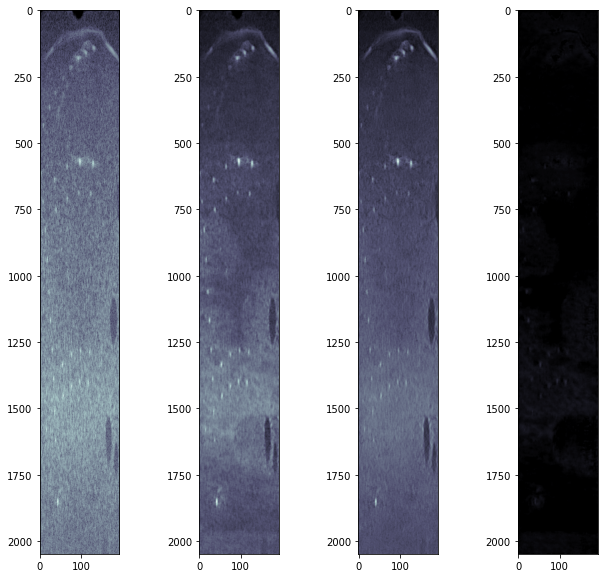

In [21]:
#@title Test Model Prediction (Non Scan Convert, Non Separable Convolution) {form-width:"33%"}
def noSC_noSepConv():
    tf.keras.backend.clear_session()
    mimick = MimickNet_NoSC.MimickDataset_NoSC(divisible=16, bs=config.bs, dataset='duke_ultrasound', data_dir='gs://duke-tfds')
    test_dataset = mimick.make_dataset(dataset_type='test')
    test_iter = iter(test_dataset)
    
    ele = next(test_iter)
    # Plot figures
    fig, axes = plt.subplots(1,4, figsize=(10,10), gridspec_kw={
        'wspace': 1,
        'hspace': 1
    })
    output = model_noSC_noSepConv.predict(ele['das'])
    axes[0].imshow(tf.squeeze(ele['das']), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[1].imshow(tf.squeeze(output), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[2].imshow(tf.squeeze(ele['dtce']), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[3].imshow(np.squeeze(output) - np.squeeze(ele['dtce'].numpy()), cmap='bone', vmin=0, vmax=1, aspect='auto')

    # Testing runtime
    t0= time.clock()
    for i in range(config.bs):
        ele = next(test_iter)
        output = model_noSC_noSepConv.predict(ele['das'])
    t1 = time.clock() - t0
    print("Time elapsed to test no scan convert, no separable conv. model with {} images: {}".format(config.bs, t1))

    # Testing SSIM
    test_iter = iter(test_dataset)
    ele = next(test_iter)
    ele = next(test_iter)
    total_ssim = []
    for i in range(config.bs):
        ele = next(test_iter)
        output = model_noSC_noSepConv.predict(ele['das'])
        total_ssim.append(utils.ssim(ele['dtce'], output).numpy())
    print("Average SSIM of {} images: {}".format(config.bs, sum(total_ssim) / len(total_ssim)))

noSC_noSepConv()

Time elapsed to test no scan convert, separable conv. model with 8 images: 1.8792399999999816
Average SSIM of 8 images: [0.92866564]


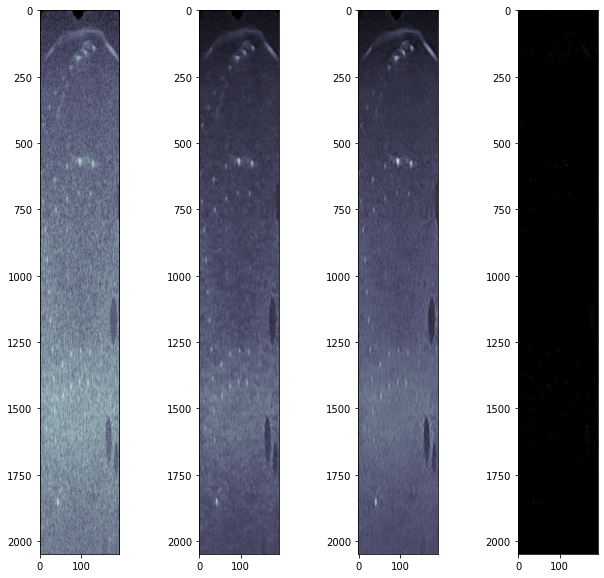

In [22]:
#@title Test Model Prediction (Non Scan Convert, Separable Convolution) {form-width:"33%"}
def noSC_SepConv():
    tf.keras.backend.clear_session()
    mimick = MimickNet_NoSC.MimickDataset_NoSC(divisible=16, bs=config.bs, dataset='duke_ultrasound', data_dir='gs://duke-tfds')
    test_dataset = mimick.make_dataset(dataset_type='test')
    test_iter = iter(test_dataset)
    
    ele = next(test_iter)
    # Plot figures
    fig, axes = plt.subplots(1,4, figsize=(10,10), gridspec_kw={
        'wspace': 1,
        'hspace': 1
    })
    output = model_noSC_SepConv.predict(ele['das'])
    axes[0].imshow(tf.squeeze(ele['das']), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[1].imshow(tf.squeeze(output), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[2].imshow(tf.squeeze(ele['dtce']), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[3].imshow(np.squeeze(output) - np.squeeze(ele['dtce'].numpy()), cmap='bone', vmin=0, vmax=1, aspect='auto')

    # Testing runtime
    t0= time.clock()
    for i in range(config.bs):
        ele = next(test_iter)
        output = model_noSC_SepConv.predict(ele['das'])
    t1 = time.clock() - t0
    print("Time elapsed to test no scan convert, separable conv. model with {} images: {}".format(config.bs, t1))

    # Testing SSIM
    test_iter = iter(test_dataset)
    ele = next(test_iter)
    ele = next(test_iter)
    total_ssim = []
    for i in range(config.bs):
        ele = next(test_iter)
        output = model_noSC_SepConv.predict(ele['das'])
        total_ssim.append(utils.ssim(ele['dtce'], output).numpy())
    print("Average SSIM of {} images: {}".format(config.bs, sum(total_ssim) / len(total_ssim)))

noSC_SepConv()

Time elapsed to test scan convert, no separable conv. model with 8 images: 44.55148000000008
Average SSIM of 8 images: 0.9242829605937004


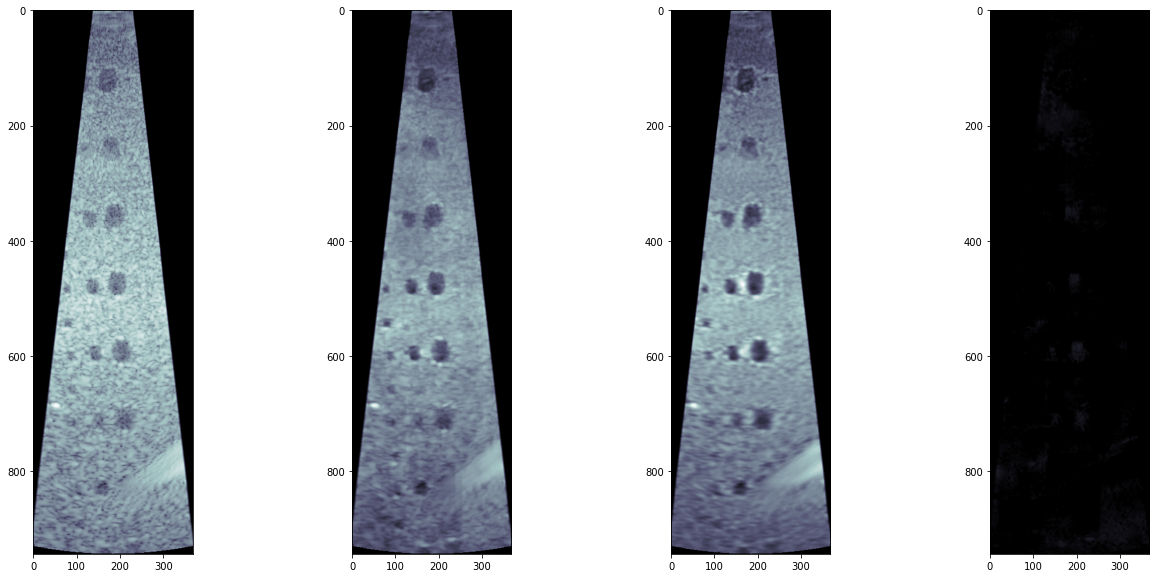

In [23]:
#@title Test Model Prediction (Scan Convert, Non Separable Convolution) {form-width:"33%"}
def SC_noSepConv():
    tf.keras.backend.clear_session()
    mimick = MimickNet_SC.MimickDataset_SC(divisible=16, bs=config.bs, dataset='duke_ultrasound', data_dir='gs://duke-tfds')
    test_dataset = mimick.make_dataset(dataset_type='test')
    test_iter = iter(test_dataset)
    
    ele = next(test_iter)
    ele = next(test_iter)
    # Plot figures
    fig, axes = plt.subplots(1,4, figsize=(20,10), gridspec_kw={
        'wspace': 1,
        'hspace': 1
    })
    output = model_SC_noSepConv.predict(ele['das'])
    axes[0].imshow(tf.squeeze(ele['das']), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[1].imshow(tf.squeeze(output), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[2].imshow(tf.squeeze(ele['dtce']), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[3].imshow(np.squeeze(output) - np.squeeze(ele['dtce'].numpy()), cmap='bone', vmin=0, vmax=1, aspect='auto')

    # Testing runtime
    t0= time.clock()
    for i in range(config.bs):
        ele = next(test_iter)
        output = model_SC_noSepConv.predict(ele['das'])
    t1 = time.clock() - t0
    print("Time elapsed to test scan convert, no separable conv. model with {} images: {}".format(config.bs, t1))

    # Testing SSIM
    test_iter = iter(test_dataset)
    ele = next(test_iter)
    ele = next(test_iter)
    total_ssim = []
    for i in range(config.bs):
        ele = next(test_iter)
        output = model_SC_noSepConv.predict(ele['das'])
        ele['dtce'] = tf.squeeze(ele['dtce'], axis = 0)
        output = tf.squeeze(output, axis = 0)
        total_ssim.append(utils.custom_ssim(ele['dtce'], output)[0].numpy())
    print("Average SSIM of {} images: {}".format(config.bs, sum(total_ssim) / len(total_ssim)))

SC_noSepConv()

Time elapsed to test scan convert, separable conv. model with 8 images: 44.35593099999983
Average SSIM of 8 images: 0.9152351915836334


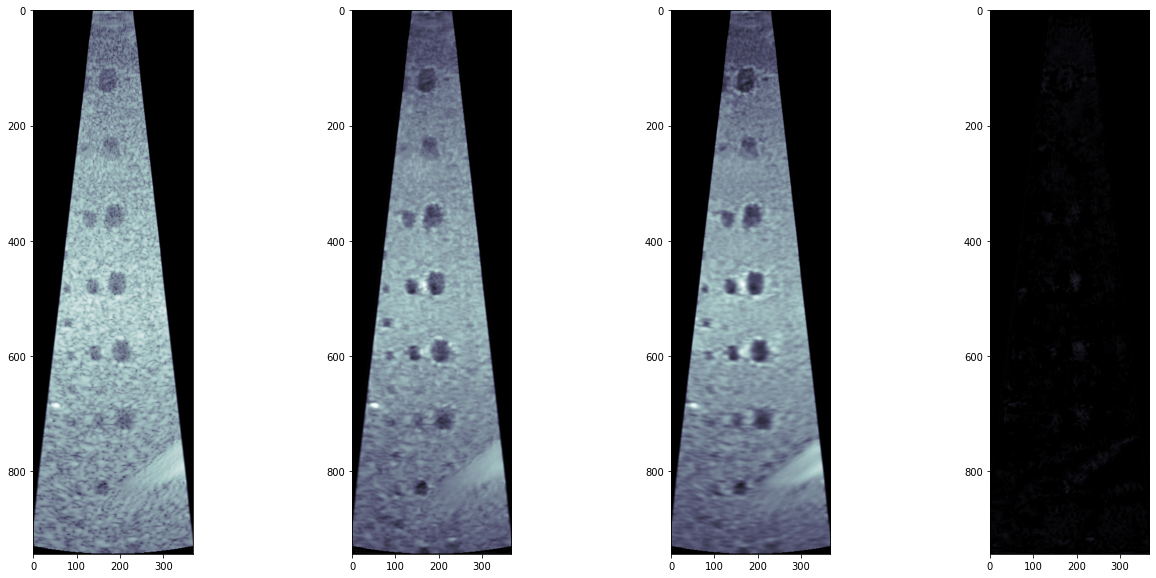

In [24]:
#@title Test Model Prediction (Scan Convert, Separable Convolution) {form-width:"33%"}
def SC_SepConv():
    tf.keras.backend.clear_session()
    mimick = MimickNet_SC.MimickDataset_SC(divisible=16, bs=config.bs, dataset='duke_ultrasound', data_dir='gs://duke-tfds')
    test_dataset = mimick.make_dataset(dataset_type='test')
    test_iter = iter(test_dataset)
    
    ele = next(test_iter)
    ele = next(test_iter)
    # Plot figures
    fig, axes = plt.subplots(1,4, figsize=(20,10), gridspec_kw={
        'wspace': 1,
        'hspace': 1
    })
    output = model_SC_SepConv.predict(ele['das'])
    axes[0].imshow(tf.squeeze(ele['das']), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[1].imshow(tf.squeeze(output), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[2].imshow(tf.squeeze(ele['dtce']), cmap='bone', vmin=0, vmax=1, aspect='auto')
    axes[3].imshow(np.squeeze(output) - np.squeeze(ele['dtce'].numpy()), cmap='bone', vmin=0, vmax=1, aspect='auto')

    # Testing runtime
    t0= time.clock()
    for i in range(config.bs):
        ele = next(test_iter)
        output = model_SC_SepConv.predict(ele['das'])
    t1 = time.clock() - t0
    print("Time elapsed to test scan convert, separable conv. model with {} images: {}".format(config.bs, t1))

    # Testing SSIM
    test_iter = iter(test_dataset)
    ele = next(test_iter)
    ele = next(test_iter)
    total_ssim = []
    for i in range(config.bs):
        ele = next(test_iter)
        output = model_SC_SepConv.predict(ele['das'])
        ele['dtce'] = tf.squeeze(ele['dtce'], axis = 0)
        output = tf.squeeze(output, axis = 0)
        total_ssim.append(utils.custom_ssim(ele['dtce'], output)[0].numpy())
    print("Average SSIM of {} images: {}".format(config.bs, sum(total_ssim) / len(total_ssim)))

SC_SepConv()